In [584]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad
import einops

import numpy as np
import matplotlib.pyplot as plt
import copy

In [121]:
def SO3_gens():
    Lz = torch.tensor([[0,1,0],[-1,0,0],[0,0,0]],dtype = torch.float32)
    Ly = torch.tensor([[0,0,-1],[0,0,0],[1,0,0]],dtype = torch.float32)
    Lx = torch.tensor([[0,0,0],[0,0,1],[0,-1,0]],dtype = torch.float32)
    gens = [Lx, Ly, Lz]
    return gens

In [180]:
def Lorentz_gens():

    #p^a= p[a] -> Jz[a,b]p[b] (p_a = p[a] -> Jz[a,b]p[b])
    Lz = torch.tensor([[0,0,0,0],[0,0,1,0],[0,-1,0,0],[0,0,0,0]],dtype = torch.float32)
    Ly = torch.tensor([[0,0,0,0],[0,0,0,-1],[0,0,0,0],[0,1,0,0]],dtype = torch.float32)
    Lx = torch.tensor([[0,0,0,0],[0,0,0,0],[0,0,0,1],[0,0,-1,0]],dtype = torch.float32)


    #p^a = p[a] -> Kz[a,b]p[b] (p_a = p[a] -> -Kz[a,b]p[b])
    Kz = torch.tensor([[0,0,0,1],[0,0,0,0],[0,0,0,0],[1,0,0,0]],dtype = torch.float32)
    Ky = torch.tensor([[0,0,1,0],[0,0,0,0],[1,0,0,0],[0,0,0,0]],dtype = torch.float32)
    Kx = torch.tensor([[0,1,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]],dtype = torch.float32)

    gens = [Kx, Ky, Kz, Lx, Ly, Lz]
    return gens

In [123]:
gens_SO3 = einops.rearrange(SO3_gens(),'n h w -> n h w')

In [181]:
gens_Lorentz = einops.rearrange(Lorentz_gens(),'n h w -> n h w')

In [124]:
gens_SO3

tensor([[[ 0.,  0.,  0.],
         [ 0.,  0.,  1.],
         [ 0., -1.,  0.]],

        [[ 0.,  0., -1.],
         [ 0.,  0.,  0.],
         [ 1.,  0.,  0.]],

        [[ 0.,  1.,  0.],
         [-1.,  0.,  0.],
         [ 0.,  0.,  0.]]])

In [137]:
gens_Lorentz

tensor([[[ 0., -1.,  0.,  0.],
         [ 1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0., -1.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 1.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  1.],
         [ 0.,  0., -1.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  0.],
         [ 0., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]]])

In [32]:
gens_SO3.shape[-1]

3

In [243]:
devicef = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [249]:
class SymmLoss(nn.Module):

    def __init__(self, gens_list,model,device = devicef):
        super(SymmLoss, self).__init__()
        
        self.model = model.to(device)
        self.device = device
        # Initialize generators (in future add different reps for inputs?)
        self.generators = einops.rearrange(gens_list, 'n w h -> n w h')
        self.generators = self.generators.to(device)
        

    
    def forward(self, input, model_rep='scalar',norm = "none"):
        
        input = input.clone().detach().requires_grad_(True)
        input = input.to(self.device)
        # Compute model output, shape [B]
        output = self.model(input)

        # Compute gradients with respect to input, shape [B, d*N], B is the batch size, d is the inpur irrep dimension, N is the number of particles
        grads, = torch.autograd.grad(outputs=output, inputs=input, grad_outputs=torch.ones_like(output, device=self.device), create_graph=True)
        
        # Reshape grads to [B, N, d] 
        grads = einops.rearrange(grads, '... (N d) -> ... N d',d = self.generators.shape[-1])

        # Contract grads with generators, shape [n (generators), B, N, d]
        gen_grads = torch.einsum('n h d, ... N h->  n ... N d ',self.generators, grads)
        # Reshape to [n, B, (d N)]
        gen_grads = einops.rearrange(gen_grads, 'n ... N d -> n ... (N d)')

        # Dot with input [n ,B]
        differential_trans = torch.einsum('n ... N, ... N -> n ...', gen_grads, input)

        
        # # Reshape grads to [B, N, d] 
        # grads = einops.rearrange(grads, '(N d) -> N d',d = self.generators.shape[-1])

        # # Contract grads with generators, shape [n (generators), B, N, d]
        # gen_grads = torch.einsum('n h d,  N h->  n N d ',self.generators, grads)
        # # Reshape to [n, B, (d N)]
        # gen_grads = einops.rearrange(gen_grads, 'n N d -> n (N d)')

        # # Dot with input [n ,B]
        # differential_trans = torch.einsum('n N, N -> n', gen_grads, input)

        scalar_loss = (differential_trans ** 2).sum()
     
            
        return scalar_loss

In [254]:
class inv_model(nn.Module):

    def __init__(self,dinput = 4, doutput = 1,init = "rand"):
        super(inv_model,self).__init__()

        bi_tensor = torch.randn(dinput,dinput)

        if init=="eta":
            diag = torch.ones(dinput)*(-1.00)
            diag[0]=1.00
            bi_tensor = torch.diag(diag)

        elif init=="delta":
            bi_tensor = torch.diag(torch.ones(dinput)*1.00)
        
        
        bi_tensor = (bi_tensor+torch.transpose(bi_tensor,0,1))*0.5
        self.bi_tensor = torch.nn.Parameter(bi_tensor)
        self.bi_tensor.requires_grad_()

    def forward(self,x, sig = "euc", d = 3 ):
        #y = x @ (self.bi_tensor @ x.T)
        y = torch.einsum("...i,ij,...j-> ...",x,self.bi_tensor,x)
        # x = torch.dot(x,y)
        return y


In [724]:
class genNet(nn.Module):
    def __init__(self, input_size=4, output_size=1, hidden_size=10, n_hidden_layers=3, init="rand", equiv="False", rand = "True", freeze = "False",activation = "ReLU",skip = "False"):
        super().__init__()
        self.equiv=equiv
        self.skip = skip
        if rand=="False":
            np.random.seed(98235)
            torch.manual_seed(98235)

        if activation =="sigmoid":
            #input layer
            module_list = [nn.Linear(input_size, hidden_size), nn.Sigmoid()]
            # hidden layers
            for _ in range(n_hidden_layers):
                module_list.extend([nn.Linear(hidden_size, hidden_size), nn.Sigmoid()])

        else:
            #input layer
            module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
            # hidden layers
            for _ in range(n_hidden_layers):
                module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        # output layer
        module_list.append(nn.Linear(hidden_size, output_size))

        self.sequential = nn.Sequential(*module_list)

        dinput = input_size
        if self.equiv=="True":
            bi_tensor = torch.randn(input_size,input_size)

            if init=="eta":
                diag = torch.ones(dinput)*(-1.00)
                diag[0]=1.00
                bi_tensor = torch.diag(diag)

            elif init=="delta":
                bi_tensor = torch.diag(torch.ones(dinput)*1.00)
        
            bi_tensor = (bi_tensor+torch.transpose(bi_tensor,0,1))*0.5
            self.bi_tensor = bi_tensor.to(devicef)
            
            if (freeze =="False" or freeze == False):
                self.bi_tensor = torch.nn.Parameter(bi_tensor)
                self.bi_tensor.requires_grad_()

            self.equiv_layer = nn.Linear(1, input_size)
            self.skip_layer = nn.Linear(input_size, input_size)

    def forward(self,x):

        if self.equiv=="True":
            y = torch.einsum("...i,ij,...j-> ...",x,self.bi_tensor,x).unsqueeze(1)
            
            if self.skip =="True":
                y = self.equiv_layer(y) + self.skip_layer(x)
            else:
                y = self.equiv_layer(y)

            
        else:
            y = x

        return self.sequential(y)
        
        


In [721]:
class symm_net_train():

    def __init__(self,gens_list=gens_Lorentz,input_size = 4,init = "rand",equiv="False",rand="False",freeze = "False", activation = "ReLU",skip="False"):
        self.train_loss = []
        self.symm_loss_vec = []
        self.tot_loss_vec = []
        self.running_loss = 0.0
        self.symm_loss = 0.0
        self.train_loss = {}
        self.symm_loss = {}
        self.tot_loss = {}
        self.models = {}
        self.init = init
        self.equiv = equiv
        self.rand=rand
        self.freeze = freeze, 
        self.activation = activation
        self.skip=skip

    def Lorentz_myfun(input):
        m2 = torch.einsum("... i, ij, ...j -> ...",input, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])), input)
        out = m2**2+15*m2
        return out.unsqueeze(1)

    def prepare_dataset(self, N = 1000, dinput = 4, norm = 1, true_func = Lorentz_myfun, batch_size="all", shuffle=False, seed = 98235):

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        train_data = (torch.rand(N,dinput)-0.5)*norm
        #train_m2 = torch.einsum("... i, ij, ...j -> ...",train_data, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])), train_data)
        train_labels = true_func(train_data)
        
        if batch_size=="all":
            batch_size = N

        # train_labels = torch.tensor(train_labels, dtype=torch.float32)
        # train_data = torch.tensor(train_data, dtype=torch.float32)
        train_dataset = TensorDataset(train_data,train_labels)
        self.train_dataset = train_dataset
        self.train_data = train_data
        self.train_labels = train_labels
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    def set_model(self,gens_list=gens_Lorentz,input_size = 4,init = "rand",equiv="False",rand="False",freeze = "False", activation = "ReLU",skip="False"):
        self.init = init
        self.equiv = equiv
        self.rand=rand
        self.freeze = freeze, 
        self.activation = activation
        self.skip=skip

    def title(self):
        text = ""
        if self.equiv== "True":
            text=f"{text} bi-linear layer"
            if self.skip =="True":
                text=f"{text} skip"
            if self.init=="eta" or self.init=="delta":
                text=f"{text} init: {self.init}"
            if self.freeze=="True":
                text=f"{text} freeze"
        self.title_text = text
        return text


    def run_training(self,train_loader,nepochs = 1000,lam_vec = [0.0],seed = 98235):
        
        
        lam = lam_vec
        # Train the model, store train and test loss, print the loss every epoch
        train_loss = []
        symm_loss_vec = []
        tot_loss_vec = []
        running_loss = 0.0
        symm_loss = 0.0
        train_loss = {}
        symm_loss = {}
        tot_loss = {}
        models = {}

        if train_loader =="self":

            train_loader = self.train_loader


        for lam_val in lam:

            np.random.seed(seed)
            torch.manual_seed(seed)
            self.prepare_dataset()
            modelLorentz_symm = genNet(input_size = self.input_size, init = self.init ,equiv=self.equiv,rand=self.rand,freeze = self.freeze,activation = self.activation, skip = self.skip)

            model = modelLorentz_symm.to(devicef)
        
            # Define the loss function and optimizer
            optimizer = optim.Adam(model.parameters(), lr=1e-3)
            criterion = nn.MSELoss()
            criterion_Lorentz = SymmLoss(gens_list=gens_list, model = model)

            train_loss = []
            symm_loss_vec = []
            tot_loss_vec = []
            running_loss = 0.0
            symm_loss = 0.0

            for epoch in range(nepochs):
                model.train()
                running_loss = 0.0
                symm_loss = 0.0
                for i, data in enumerate(train_loader):
                    inputs, labels = data
                    labels = torch.unsqueeze(labels.to(devicef),1)
                    inputs = inputs.to(devicef)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss_symm = criterion_Lorentz(input = inputs)
                    loss_tot = loss+lam_val*loss_symm
                    loss_tot.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    symm_loss += loss_symm.item()
                train_loss.append(running_loss / len(train_loader))
                symm_loss_vec.append(symm_loss / len(train_loader))
                tot_loss_vec.append((lam_val*symm_loss+running_loss) / len(train_loader))
                if epoch % 100 == 0:
                    print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:}, Lorentz loss: {symm_loss_vec[-1]:}")
                    
            
            self.train_loss[lam_val] = train_loss
            self.symm_loss[lam_val] = symm_loss_vec
            self.tot_loss[lam_val] = tot_loss_vec
            
            model_clone = copy.deepcopy(model)
            self.models[lam_val] = model_clone#model.load_state_dict(model.state_dict())
            if self.equiv =="True": 
                print(f"bi-linear tensor layer:{model.bi_tensor}")
                if self.skip =="True":
                    print(f"skip layer:{model.skip_layer}")


    def plot_losses(self):

        color_vec = ["violet","blue","green","yellow","orange","red","pink"]
        train_loss_lam = self.train_loss_lam
        symm_loss_lam = self.symm_loss_lam
        models = self.models_lam
        
        plt.figure()
        for i,lam_val in enumerate(models.keys()):
            plt.semilogy(range(len(train_loss_lam[lam_val])),train_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, MSE", color = color_vec[i])
            plt.semilogy(range(len(symm_loss_lam[lam_val])),symm_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, symm", color = color_vec[i],ls = "--")
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("loss")
        text = self.title()
        plt.title(text)
    
    def plot_symm_loss(self):
        color_vec = ["violet","blue","green","yellow","orange","red","pink"]
        #train_loss_lam = self.train_loss_lam
        symm_loss_lam = self.symm_loss_lam
        models = self.models_lam
        
        plt.figure()
        for i,lam_val in enumerate(models.keys()):
            #plt.semilogy(range(len(train_loss_lam[lam_val])),train_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, MSE", color = color_vec[i])
            plt.semilogy(range(len(symm_loss_lam[lam_val])),symm_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, symm", color = color_vec[i])
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("symm loss")
        text = self.title()
        plt.title(text)

    
    def plot_symm_loss(self):
        color_vec = ["violet","blue","green","yellow","orange","red","pink"]
        train_loss_lam = self.train_loss_lam
        #symm_loss_lam = self.symm_loss_lam
        models = self.models_lam
        
        plt.figure()
        for i,lam_val in enumerate(models.keys()):
            plt.semilogy(range(len(train_loss_lam[lam_val])),train_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, MSE", color = color_vec[i])
            #plt.semilogy(range(len(symm_loss_lam[lam_val])),symm_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, symm", color = color_vec[i])
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("MSE loss")
        text = self.title()
        plt.title(text)
    
    def pred_plot(self):
        inputs = self.train_data
        for lam_val in self.models.keys():
        plt.figure()
        plt.scatter(self.labels.cpu().squeeze(),self.models[lam_val](inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val}")
        #plt.scatter(self.true_func(inputs).cpu().squeeze(),models_bi_SGD[lam_val](more_inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val} test",color = "violet")
        plt.legend()
        plt.xlabel("truth")
        plt.ylabel("pred")
        



        

IndentationError: expected an indented block after 'for' statement on line 195 (3185307059.py, line 196)

In [714]:
symm_net = symm_net_train()

In [715]:
symm_net.prepare_dataset()

In [716]:
symm_net.train_data

tensor([[-0.3082,  0.3341,  0.0797, -0.2904],
        [-0.4634,  0.1479, -0.4426,  0.4071],
        [-0.4521,  0.2916, -0.3723, -0.1675],
        ...,
        [-0.2914, -0.3693,  0.2285,  0.0880],
        [-0.3162, -0.0568, -0.3672,  0.3930],
        [ 0.3616,  0.0833,  0.1489,  0.4251]])

In [111]:
dinput = 3
N = 100
norm = 1


train_data = (torch.rand(N,dinput)-0.5)*norm
train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=N, shuffle=True)

In [96]:
train_data.shape

torch.Size([100, 3])

In [132]:
loss = SymmLoss(gens_list=gens_SO3, model = mymodel)

In [133]:
loss_res = loss(input = train_data[0])

torch.Size([1, 3])
tensor([[[ 0.,  0.,  0.],
         [ 0.,  0.,  1.],
         [ 0., -1.,  0.]],

        [[ 0.,  0., -1.],
         [ 0.,  0.,  0.],
         [ 1.,  0.,  0.]],

        [[ 0.,  1.,  0.],
         [-1.,  0.,  0.],
         [ 0.,  0.,  0.]]])


In [134]:
loss_res

tensor(0.0013, grad_fn=<SumBackward0>)

In [141]:
dinput = 4
N = 100
norm = 1

train_data = (torch.rand(N,dinput)-0.5)*norm
train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=N, shuffle=True)

In [255]:
mymodelLorentz = inv_model(dinput = 4, init = "eta")

In [251]:
lossLorentz = SymmLoss(gens_list=gens_Lorentz, model = mymodelLorentz)

In [256]:
mymodelLorentz(train_data).device

device(type='cpu')

In [261]:
for input in train_loader:
    #print(input[0])
    print(mymodelLorentz(input[0]))

tensor([-0.2852, -0.0929, -0.0760, -0.2588,  0.0675, -0.0249, -0.1588, -0.4376,
        -0.1655, -0.4206, -0.2606, -0.0141, -0.1525,  0.0661, -0.1820, -0.0863,
        -0.2985, -0.1618, -0.2116, -0.2700, -0.1487, -0.0756,  0.0368, -0.0627,
        -0.0826, -0.3202, -0.0965,  0.0878, -0.2815, -0.2705, -0.1527, -0.0421,
        -0.2306,  0.0303, -0.1567,  0.0133, -0.2333, -0.1098, -0.3114, -0.2298,
         0.0734, -0.0990, -0.3101, -0.2211,  0.0241, -0.2023,  0.0024, -0.2150,
        -0.2479, -0.0760, -0.2314, -0.0468, -0.3119,  0.0094, -0.0216, -0.1980,
        -0.2268, -0.2623, -0.0037, -0.1788, -0.1725, -0.3563, -0.0664, -0.3658,
        -0.2154,  0.0048, -0.1867, -0.3787, -0.1710, -0.1038, -0.3200,  0.0609,
         0.1093, -0.1735, -0.0106,  0.0238, -0.2488, -0.0792,  0.0104,  0.0407,
         0.1646, -0.1426, -0.0479, -0.1609,  0.0772, -0.0635, -0.1427, -0.4309,
        -0.0488, -0.2398, -0.1089, -0.3775, -0.0304, -0.6973, -0.2707, -0.0944,
        -0.0405, -0.2420, -0.0383, -0.35

In [227]:
mymodelLorentz(train_data[0])

tensor(-0.4309, grad_fn=<ViewBackward0>)

In [162]:
beta = 0.6
gamma = 1/np.sqrt(1-beta**2)
LorentzBoost = torch.tensor([[gamma, -gamma*beta,  0, 0],[-gamma*beta, gamma, 0, 0],[0,0,1,0],[0,0,0,1]],dtype = torch.float32)

In [163]:
mymodelLorentz(torch.einsum("ij,j-> i",LorentzBoost,train_data[0]))

tensor(-0.4309, grad_fn=<DotBackward0>)

In [258]:
loss_res = lossLorentz(input = train_data)

In [259]:
loss_res

tensor(0., device='mps:0', grad_fn=<SumBackward0>)

In [265]:
mymodelLorentz = inv_model(dinput = 4, init = "eta")
lossLorentz = SymmLoss(gens_list=gens_Lorentz, model = mymodelLorentz)
loss_res = lossLorentz(input = train_data)
loss_res

tensor(0., device='mps:0', grad_fn=<SumBackward0>)

In [264]:
mymodelLorentz = inv_model(dinput = 4, init = "rand")
lossLorentz = SymmLoss(gens_list=gens_Lorentz, model = mymodelLorentz)
loss_res = lossLorentz(input = train_data)
loss_res

tensor(160.5939, device='mps:0', grad_fn=<SumBackward0>)

Try training

In [476]:
dinput = 4
N = 100
norm = 1


train_data = (torch.rand(N,dinput)-0.5)*norm
train_m2 = torch.einsum("... i, ij, ...j -> ...",train_data, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])), train_data)
train_labels = train_m2**2+15*train_m2
def true_fun(input):
    m2 = torch.einsum("... i, ij, ...j -> ...",input, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])), input)
    return m2**2+15*m2

# train_labels = torch.tensor(train_labels, dtype=torch.float32)
# train_data = torch.tensor(train_data, dtype=torch.float32)
train_dataset = TensorDataset(train_data,train_labels)
train_loader = DataLoader(train_dataset, batch_size=N, shuffle=False)

In [ ]:
modelLorentz_inv = inv_model(dinput = 4, init = "rand")
lossLorentz = SymmLoss(gens_list=gens_Lorentz, model = mymodelLorentz)
loss_res = lossLorentz(input = train_data)

In [397]:
np.random.seed(98235)
torch.manual_seed(98235)

In [531]:
train_data.shape

torch.Size([1000, 4])

In [539]:
modelLorentz_gen = genNet(input_size = 4, init = "eta",equiv="True")
lossLorentz_gen = SymmLoss(gens_list=gens_Lorentz, model = modelLorentz_gen)
loss_res = lossLorentz_gen(input = train_data)

torch.Size([1000, 1])
torch.Size([1000, 4])


In [540]:
loss_res

tensor(2.8443e-18, device='mps:0', grad_fn=<SumBackward0>)

In [402]:
model = modelLorentz_gen.to(devicef)
nepochs = 2000
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
#optimizer_restricted = optim.SGD(model_restricted.parameters(), lr=1e-3, momentum=0.9)

# Train the model, store train and test loss, print the loss every epoch
train_loss = []
test_loss = []
running_loss = 0.0

for epoch in range(nepochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        labels = torch.unsqueeze(labels.to(devicef),1)
        inputs = inputs.to(devicef)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))

In [352]:
print(train_loss[0])
print(train_loss[-1])

8.929766654968262
0.23898784816265106


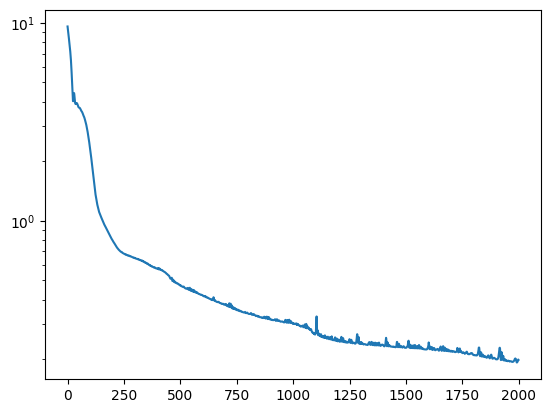

In [403]:
plt.semilogy(range(nepochs),train_loss)


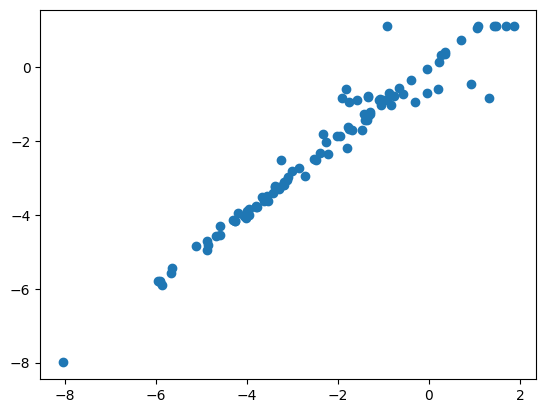

In [404]:
plt.scatter(labels.cpu().squeeze(),model(inputs).detach().cpu().squeeze())

In [458]:
np.random.seed(98235)
torch.manual_seed(98235)


In [727]:
dinput = 4
N = 1000
norm = 1

train_labels = train_m2**2+15*train_m2
train_data = (torch.rand(N,dinput)-0.5)*norm
#train_data[1] = torch.einsum("ij,j-> i",LorentzBoost,train_data[0])
#train_data.append(torch.einsum("ij,j-> i",LorentzBoost,train_data[0]))
train_m2 = torch.einsum("... i, ij, ...j -> ...",train_data, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])), train_data)


# train_labels = torch.tensor(train_labels, dtype=torch.float32)
# train_data = torch.tensor(train_data, dtype=torch.float32)
train_dataset = TensorDataset(train_data,train_labels)
train_loader = DataLoader(train_dataset, batch_size=N, shuffle=False)

In [655]:
def true_fun(input):
    m2 = torch.einsum("... i, ij, ...j -> ...",input, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])), input)
    out = m2**2+15*m2
    return out.unsqueeze(1)

In [501]:
modelLorentz_symm = genNet(input_size = 4, init = "eta",equiv="True")
lossLorentz_symm = SymmLoss(gens_list=gens_Lorentz, model = modelLorentz_symm)
loss_res = lossLorentz_gen(input = train_data)

Initialize and freeze eta

In [643]:

nepochs = 5000
# Define the loss function and optimizer

lam= [0.0, 0.1, 1,10]
#optimizer_restricted = optim.SGD(model_restricted.parameters(), lr=1e-3, momentum=0.9)

# Train the model, store train and test loss, print the loss every epoch
train_loss = []
symm_loss_vec = []
tot_loss_vec = []
running_loss = 0.0
symm_loss = 0.0
train_loss_freeze = {}
symm_loss_freeze = {}
tot_loss_freeze = {}
models_freeze = {}


for lam_val in lam[0:1]:

    np.random.seed(98235)
    torch.manual_seed(98235)
    modelLorentz_symm = genNet(input_size = 4, init = "eta",equiv="True",rand="False",freeze = "True")
    #lossLorentz_symm = SymmLoss(gens_list=gens_Lorentz, model = modelLorentz_symm)
    #loss_res = lossLorentz_gen(input = train_data)

    model = modelLorentz_symm.to(devicef)
   
    # Define the loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    criterion_Lorentz = SymmLoss(gens_list=gens_Lorentz, model = model)

    train_loss = []
    symm_loss_vec = []
    tot_loss_vec = []
    running_loss = 0.0
    symm_loss = 0.0

    for epoch in range(nepochs):
        model.train()
        running_loss = 0.0
        symm_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            labels = torch.unsqueeze(labels.to(devicef),1)
            inputs = inputs.to(devicef)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_symm = criterion_Lorentz(input = inputs)
            loss_tot = loss+lam_val*loss_symm
            loss_tot.backward()
            optimizer.step()
            running_loss += loss.item()
            symm_loss += loss_symm.item()
        train_loss.append(running_loss / len(train_loader))
        symm_loss_vec.append(symm_loss / len(train_loader))
        tot_loss_vec.append((lam_val*symm_loss+running_loss) / len(train_loader))
        if epoch % 100 == 0:
            print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")
            #print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")

    
    train_loss_freeze[lam_val] = train_loss
    symm_loss_freeze[lam_val] = symm_loss_vec
    tot_loss_freeze[lam_val] = tot_loss_vec
    #model.attribute = list(model.attribute)  # where attribute was dict_keys
    model_clone = copy.deepcopy(model)
    models_freeze[lam_val] = model_clone#model.load_state_dict(model.state_dict())
    print(model.bi_tensor)
        

lambda = 0.0 Epoch 1, MSE loss: 9.739, Lorentz loss: 5.658213174883228e-19
lambda = 0.0 Epoch 101, MSE loss: 7.524, Lorentz loss: 3.9618822613341105e-15
lambda = 0.0 Epoch 201, MSE loss: 1.161, Lorentz loss: 1.91999628001982e-11
lambda = 0.0 Epoch 301, MSE loss: 0.041, Lorentz loss: 8.026921488601957e-11
lambda = 0.0 Epoch 401, MSE loss: 0.004, Lorentz loss: 8.395295569840755e-11
lambda = 0.0 Epoch 501, MSE loss: 0.001, Lorentz loss: 8.561681918983766e-11
lambda = 0.0 Epoch 601, MSE loss: 0.001, Lorentz loss: 8.407952112321482e-11
lambda = 0.0 Epoch 701, MSE loss: 0.000, Lorentz loss: 8.424810155061024e-11
lambda = 0.0 Epoch 801, MSE loss: 0.000, Lorentz loss: 8.556796937675415e-11
lambda = 0.0 Epoch 901, MSE loss: 0.000, Lorentz loss: 8.615506918996374e-11
lambda = 0.0 Epoch 1001, MSE loss: 0.000, Lorentz loss: 8.648889937568072e-11
lambda = 0.0 Epoch 1101, MSE loss: 0.000, Lorentz loss: 8.420637798156605e-11
lambda = 0.0 Epoch 1201, MSE loss: 0.000, Lorentz loss: 8.505371407174778e-1

In [ ]:

nepochs = 5000
# Define the loss function and optimizer

lam= [0.0, 0.1, 1,10]
#optimizer_restricted = optim.SGD(model_restricted.parameters(), lr=1e-3, momentum=0.9)

# Train the model, store train and test loss, print the loss every epoch
train_loss = []
symm_loss_vec = []
tot_loss_vec = []
running_loss = 0.0
symm_loss = 0.0
train_loss_lam = {}
symm_loss_lam = {}
tot_loss_lam = {}
models = {}


for lam_val in lam[0:2]:

    np.random.seed(98235)
    torch.manual_seed(98235)
    modelLorentz_symm = genNet(input_size = 4, init = "rand",equiv="True",rand="False")
    #lossLorentz_symm = SymmLoss(gens_list=gens_Lorentz, model = modelLorentz_symm)
    #loss_res = lossLorentz_gen(input = train_data)

    model = modelLorentz_symm.to(devicef)
   
    # Define the loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    criterion_Lorentz = SymmLoss(gens_list=gens_Lorentz, model = model)

    train_loss = []
    symm_loss_vec = []
    tot_loss_vec = []
    running_loss = 0.0
    symm_loss = 0.0

    for epoch in range(nepochs):
        model.train()
        running_loss = 0.0
        symm_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            labels = torch.unsqueeze(labels.to(devicef),1)
            inputs = inputs.to(devicef)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_symm = criterion_Lorentz(input = inputs)
            loss_tot = loss+lam_val*loss_symm
            loss_tot.backward()
            optimizer.step()
            running_loss += loss.item()
            symm_loss += loss_symm.item()
        train_loss.append(running_loss / len(train_loader))
        symm_loss_vec.append(symm_loss / len(train_loader))
        tot_loss_vec.append((lam_val*symm_loss+running_loss) / len(train_loader))
        if epoch % 100 == 0:
            print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")
            #print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")

    
    train_loss_lam[lam_val] = train_loss
    symm_loss_lam[lam_val] = symm_loss_vec
    tot_loss_lam[lam_val] = tot_loss_vec
    #model.attribute = list(model.attribute)  # where attribute was dict_keys
    model_clone = copy.deepcopy(model)
    models[lam_val] = model_clone#model.load_state_dict(model.state_dict())
    print(model.bi_tensor)
        

Initialize at eta

In [644]:

nepochs = 1000
# Define the loss function and optimizer

lam= [0.0, 0.1, 1,10]
#optimizer_restricted = optim.SGD(model_restricted.parameters(), lr=1e-3, momentum=0.9)

# Train the model, store train and test loss, print the loss every epoch
train_loss = []
symm_loss_vec = []
tot_loss_vec = []
running_loss = 0.0
symm_loss = 0.0
train_loss_lam_eta = {}
symm_loss_lam_eta = {}
tot_loss_lam_eta = {}
models_eta = {}


for lam_val in lam:

    np.random.seed(98235)
    torch.manual_seed(98235)
    modelLorentz_symm = genNet(input_size = 4, init = "eta",equiv="True",rand="False")
    #lossLorentz_symm = SymmLoss(gens_list=gens_Lorentz, model = modelLorentz_symm)
    #loss_res = lossLorentz_gen(input = train_data)

    model = modelLorentz_symm.to(devicef)
   
    # Define the loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    criterion_Lorentz = SymmLoss(gens_list=gens_Lorentz, model = model)

    train_loss = []
    symm_loss_vec = []
    tot_loss_vec = []
    running_loss = 0.0
    symm_loss = 0.0

    for epoch in range(nepochs):
        model.train()
        running_loss = 0.0
        symm_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            labels = torch.unsqueeze(labels.to(devicef),1)
            inputs = inputs.to(devicef)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_symm = criterion_Lorentz(input = inputs)
            loss_tot = loss+lam_val*loss_symm
            loss_tot.backward()
            optimizer.step()
            running_loss += loss.item()
            symm_loss += loss_symm.item()
        train_loss.append(running_loss / len(train_loader))
        symm_loss_vec.append(symm_loss / len(train_loader))
        tot_loss_vec.append((lam_val*symm_loss+running_loss) / len(train_loader))
        if epoch % 100 == 0:
            print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")

    
    train_loss_lam_eta[lam_val] = train_loss
    symm_loss_lam_eta[lam_val] = symm_loss_vec
    tot_loss_lam_eta[lam_val] = tot_loss_vec
    model_clone = copy.deepcopy(model)
    models_eta[lam_val] = model_clone#model.load_state_dict(model.state_dict())
    print(model.bi_tensor)
        

lambda = 0.0 Epoch 1, MSE loss: 9.739, Lorentz loss: 5.658213174883228e-19
lambda = 0.0 Epoch 101, MSE loss: 7.522, Lorentz loss: 0.062283072620630264
lambda = 0.0 Epoch 201, MSE loss: 0.702, Lorentz loss: 390.8585510253906
lambda = 0.0 Epoch 301, MSE loss: 0.031, Lorentz loss: 89.02249908447266
lambda = 0.0 Epoch 401, MSE loss: 0.003, Lorentz loss: 8.947795867919922
lambda = 0.0 Epoch 501, MSE loss: 0.001, Lorentz loss: 1.2287014722824097
lambda = 0.0 Epoch 601, MSE loss: 0.001, Lorentz loss: 0.580562949180603
lambda = 0.0 Epoch 701, MSE loss: 0.001, Lorentz loss: 0.5077997446060181
lambda = 0.0 Epoch 801, MSE loss: 0.001, Lorentz loss: 0.5035054683685303
lambda = 0.0 Epoch 901, MSE loss: 0.001, Lorentz loss: 0.5057898163795471
Parameter containing:
tensor([[ 1.2026e+00, -8.4850e-05, -4.3891e-04, -9.3967e-05],
        [-8.4859e-05, -1.1966e+00, -4.2246e-04, -3.1362e-04],
        [-4.3893e-04, -4.2248e-04, -1.1968e+00, -3.0030e-04],
        [-9.3950e-05, -3.1359e-04, -3.0027e-04, -1.19

Text(0, 0.5, 'MSE loss')

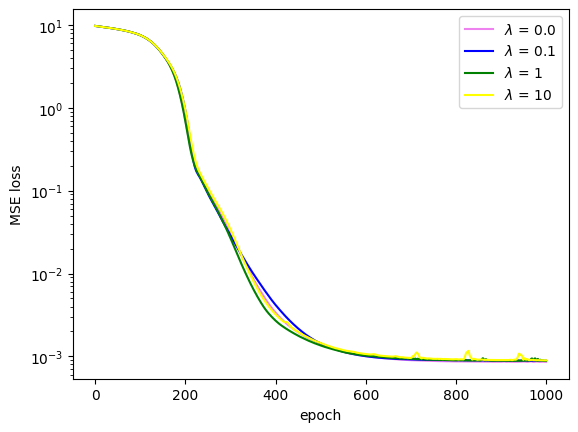

In [645]:
#nepochs = 5000
color_vec = ["violet","blue","green","yellow","orange","red","pink"]
plt.figure()
for i,lam_val in enumerate(models_eta.keys()):
    plt.semilogy(range(nepochs),train_loss_lam_eta[lam_val],label = rf"$\lambda$ = {lam_val}", color = color_vec[i])
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE loss")

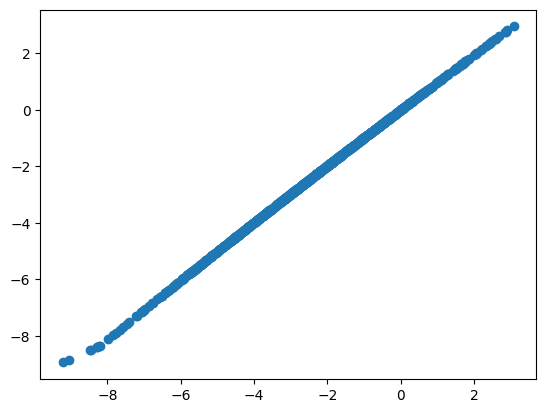

In [546]:
plt.scatter(labels.cpu().squeeze(),modelLorentz_symm(inputs).detach().cpu().squeeze())

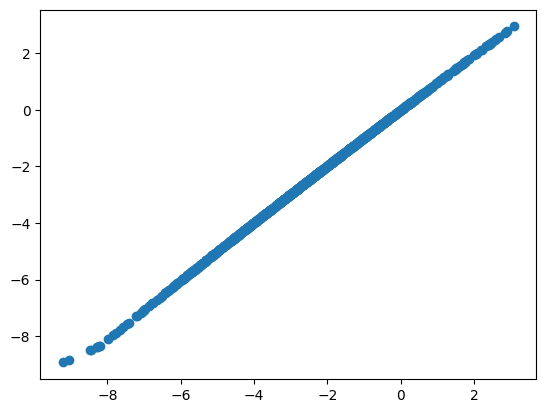

In [548]:
plt.scatter(labels.cpu().squeeze(),modelLorentz_symm(inputs).detach().cpu().squeeze())

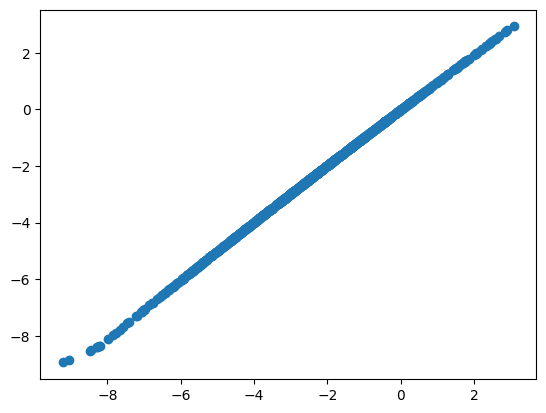

In [554]:
plt.scatter(labels.cpu().squeeze(),modelLorentz_symm(inputs).detach().cpu().squeeze())

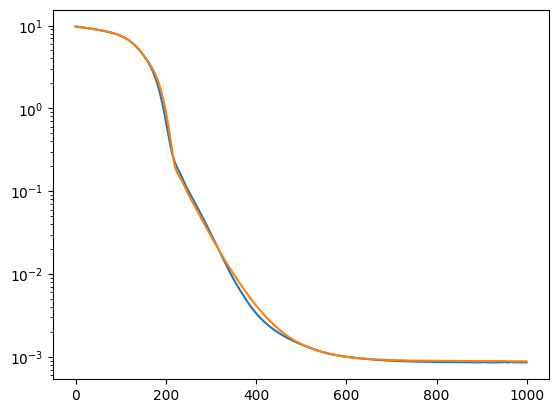

In [552]:
plt.semilogy(range(nepochs),train_loss_lam[0.0],range(nepochs),train_loss_lam[0.1])

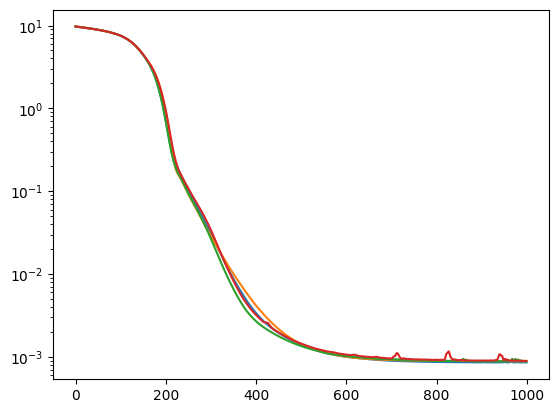

In [555]:
plt.semilogy(range(nepochs),train_loss_lam[0.0],range(nepochs),train_loss_lam[0.1],range(nepochs),train_loss_lam[1],range(nepochs),train_loss_lam[10])

Initialize randomly

In [597]:

nepochs = 5000
# Define the loss function and optimizer

lam= [0.0, 0.1, 1,10]
#optimizer_restricted = optim.SGD(model_restricted.parameters(), lr=1e-3, momentum=0.9)

# Train the model, store train and test loss, print the loss every epoch
train_loss = []
symm_loss_vec = []
tot_loss_vec = []
running_loss = 0.0
symm_loss = 0.0
train_loss_lam = {}
symm_loss_lam = {}
tot_loss_lam = {}
models = {}


for lam_val in lam[0:2]:

    np.random.seed(98235)
    torch.manual_seed(98235)
    modelLorentz_symm = genNet(input_size = 4, init = "rand",equiv="True",rand="False")
    #lossLorentz_symm = SymmLoss(gens_list=gens_Lorentz, model = modelLorentz_symm)
    #loss_res = lossLorentz_gen(input = train_data)

    model = modelLorentz_symm.to(devicef)
   
    # Define the loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    criterion_Lorentz = SymmLoss(gens_list=gens_Lorentz, model = model)

    train_loss = []
    symm_loss_vec = []
    tot_loss_vec = []
    running_loss = 0.0
    symm_loss = 0.0

    for epoch in range(nepochs):
        model.train()
        running_loss = 0.0
        symm_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            labels = torch.unsqueeze(labels.to(devicef),1)
            inputs = inputs.to(devicef)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_symm = criterion_Lorentz(input = inputs)
            loss_tot = loss+lam_val*loss_symm
            loss_tot.backward()
            optimizer.step()
            running_loss += loss.item()
            symm_loss += loss_symm.item()
        train_loss.append(running_loss / len(train_loader))
        symm_loss_vec.append(symm_loss / len(train_loader))
        tot_loss_vec.append((lam_val*symm_loss+running_loss) / len(train_loader))
        if epoch % 100 == 0:
            print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")
            #print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")

    
    train_loss_lam[lam_val] = train_loss
    symm_loss_lam[lam_val] = symm_loss_vec
    tot_loss_lam[lam_val] = tot_loss_vec
    #model.attribute = list(model.attribute)  # where attribute was dict_keys
    model_clone = copy.deepcopy(model)
    models[lam_val] = model_clone#model.load_state_dict(model.state_dict())
    print(model.bi_tensor)
        

lambda = 0.0 Epoch 1, MSE loss: 9.739, Lorentz loss: 0.0008670780807733536
lambda = 0.0 Epoch 101, MSE loss: 7.304, Lorentz loss: 0.36769452691078186
lambda = 0.0 Epoch 201, MSE loss: 4.496, Lorentz loss: 97.7746810913086
lambda = 0.0 Epoch 301, MSE loss: 3.929, Lorentz loss: 1697.472412109375
lambda = 0.0 Epoch 401, MSE loss: 2.803, Lorentz loss: 11008.681640625
lambda = 0.0 Epoch 501, MSE loss: 2.402, Lorentz loss: 17937.052734375
lambda = 0.0 Epoch 601, MSE loss: 2.140, Lorentz loss: 25053.74609375
lambda = 0.0 Epoch 701, MSE loss: 2.094, Lorentz loss: 25228.96875
lambda = 0.0 Epoch 801, MSE loss: 2.067, Lorentz loss: 27270.09375
lambda = 0.0 Epoch 901, MSE loss: 2.053, Lorentz loss: 27136.935546875
lambda = 0.0 Epoch 1001, MSE loss: 2.043, Lorentz loss: 26898.93359375
lambda = 0.0 Epoch 1101, MSE loss: 2.036, Lorentz loss: 27391.2109375
lambda = 0.0 Epoch 1201, MSE loss: 2.032, Lorentz loss: 27588.8125
lambda = 0.0 Epoch 1301, MSE loss: 2.027, Lorentz loss: 27239.21484375
lambda = 

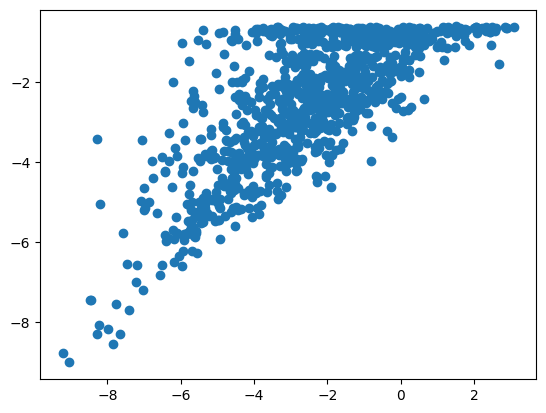

In [598]:
plt.scatter(labels.cpu().squeeze(),models[0.0](inputs).detach().cpu().squeeze())

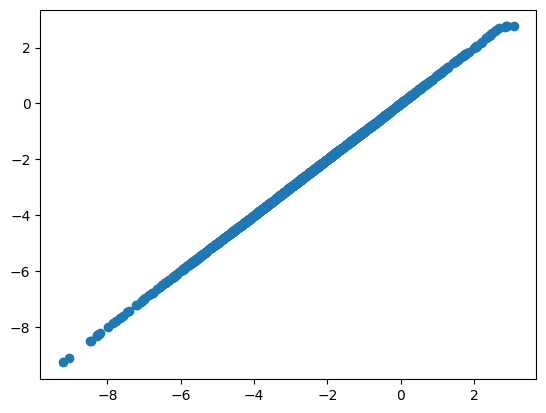

In [599]:
plt.scatter(labels.cpu().squeeze(),models[0.1](inputs).detach().cpu().squeeze())

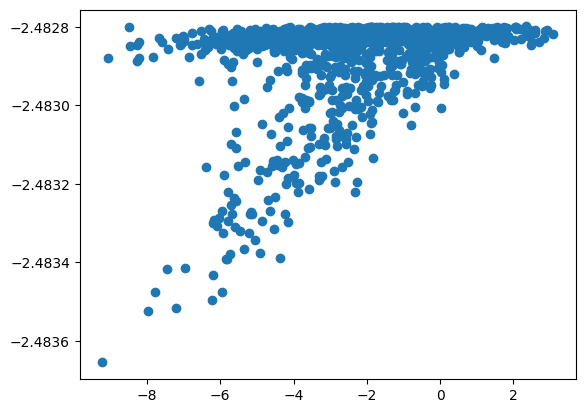

In [595]:
plt.scatter(labels.cpu().squeeze(),models[1.0](inputs).detach().cpu().squeeze())

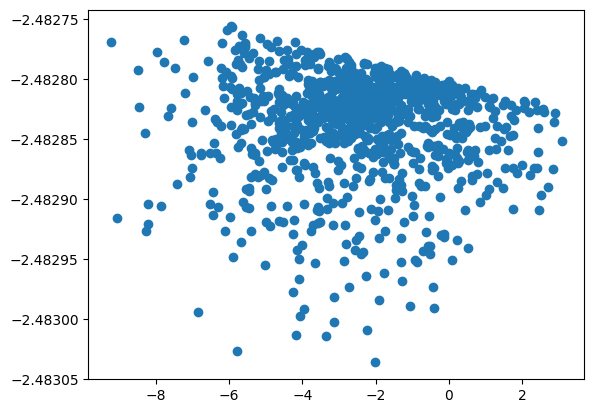

In [596]:
plt.scatter(labels.cpu().squeeze(),models[10](inputs).detach().cpu().squeeze())

In [608]:
models[0.0].bi_tensor

Parameter containing:
tensor([[-7.5547e-01, -3.6886e-04,  4.2902e-02,  5.1639e-02],
        [-3.6895e-04,  5.2631e-01, -9.2278e-01, -1.0544e+00],
        [ 4.2902e-02, -9.2278e-01,  1.2015e+00, -8.1684e-01],
        [ 5.1639e-02, -1.0544e+00, -8.1684e-01,  9.1606e-01]], device='mps:0',
       requires_grad=True)

In [609]:
models[0.1].bi_tensor

Parameter containing:
tensor([[-9.3626e-01,  2.0163e-05,  2.1502e-05,  2.2886e-05],
        [ 2.0091e-05,  9.3629e-01,  1.9519e-05,  2.1882e-05],
        [ 2.1479e-05,  1.9464e-05,  9.3630e-01,  2.2410e-05],
        [ 2.2877e-05,  2.1922e-05,  2.2354e-05,  9.3629e-01]], device='mps:0',
       requires_grad=True)

Text(0, 0.5, 'symm loss')

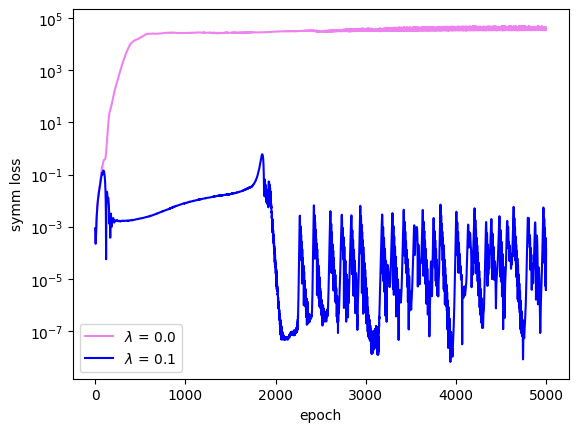

In [634]:
nepochs = 5000
color_vec = ["violet","blue","green","yellow","orange","red","pink"]
plt.figure()
for i,lam_val in enumerate(models.keys()):
    plt.semilogy(range(nepochs),symm_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}", color = color_vec[i])
plt.legend()
plt.xlabel("epoch")
plt.ylabel("symm loss")

Text(0, 0.5, 'MSE loss')

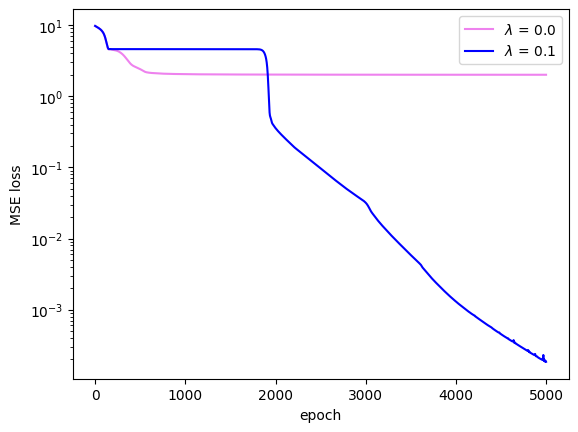

In [633]:
nepochs = 5000
color_vec = ["violet","blue","green","yellow","orange","red","pink"]
plt.figure()
for i,lam_val in enumerate(models.keys()):
    plt.semilogy(range(nepochs),train_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}", color = color_vec[i])
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE loss")

Text(0.5, 1.0, 'with bi-linear layer')

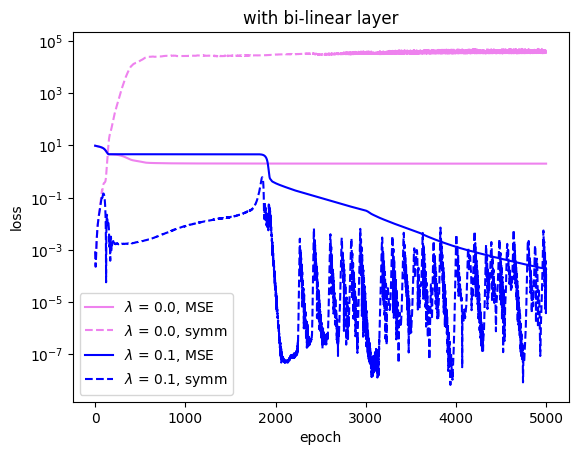

In [637]:
nepochs = 5000
color_vec = ["violet","blue","green","yellow","orange","red","pink"]
plt.figure()
for i,lam_val in enumerate(models.keys()):
    plt.semilogy(range(nepochs),train_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, MSE", color = color_vec[i])
    plt.semilogy(range(nepochs),symm_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, symm", color = color_vec[i],ls = "--")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("with bi-linear layer")

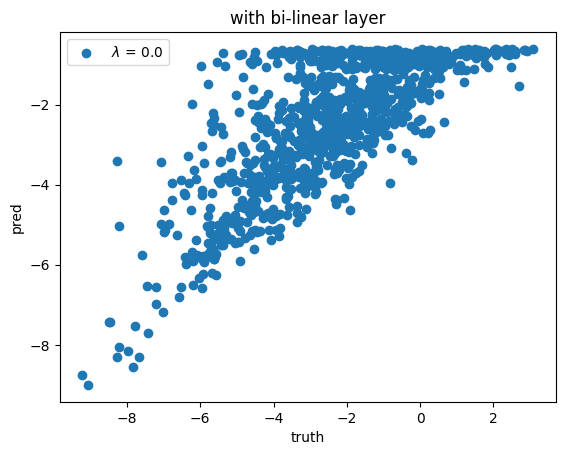

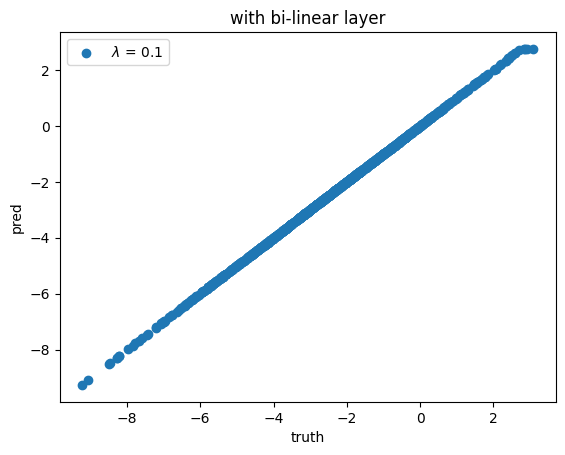

In [638]:
for lam_val in models.keys():
    plt.figure()
    plt.scatter(labels.cpu().squeeze(),models[lam_val](inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val}")
    plt.legend()
    plt.xlabel("truth")
    plt.ylabel("pred")
    plt.title("with bi-linear layer")

In [725]:

nepochs = 5000
# Define the loss function and optimizer

lam= [0.0, 0.1, 1,10]
#optimizer_restricted = optim.SGD(model_restricted.parameters(), lr=1e-3, momentum=0.9)

# Train the model, store train and test loss, print the loss every epoch
train_loss = []
symm_loss_vec = []
tot_loss_vec = []
running_loss = 0.0
symm_loss = 0.0
train_loss_lam = {}
symm_loss_lam = {}
tot_loss_lam = {}
models = {}


for lam_val in lam[0:2]:

    np.random.seed(98235)
    torch.manual_seed(98235)
    modelLorentz_symm = genNet(input_size = 4, init = "rand",equiv="True",rand="False")
    #lossLorentz_symm = SymmLoss(gens_list=gens_Lorentz, model = modelLorentz_symm)
    #loss_res = lossLorentz_gen(input = train_data)

    model = modelLorentz_symm.to(devicef)
   
    # Define the loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    criterion_Lorentz = SymmLoss(gens_list=gens_Lorentz, model = model)

    train_loss = []
    symm_loss_vec = []
    tot_loss_vec = []
    running_loss = 0.0
    symm_loss = 0.0

    for epoch in range(nepochs):
        model.train()
        running_loss = 0.0
        symm_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            labels = torch.unsqueeze(labels.to(devicef),1)
            inputs = inputs.to(devicef)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_symm = criterion_Lorentz(input = inputs)
            loss_tot = loss+lam_val*loss_symm
            loss_tot.backward()
            optimizer.step()
            running_loss += loss.item()
            symm_loss += loss_symm.item()
        train_loss.append(running_loss / len(train_loader))
        symm_loss_vec.append(symm_loss / len(train_loader))
        tot_loss_vec.append((lam_val*symm_loss+running_loss) / len(train_loader))
        if epoch % 100 == 0:
            print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")
            #print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")

    
    train_loss_lam[lam_val] = train_loss
    symm_loss_lam[lam_val] = symm_loss_vec
    tot_loss_lam[lam_val] = tot_loss_vec
    #model.attribute = list(model.attribute)  # where attribute was dict_keys
    model_clone = copy.deepcopy(model)
    models[lam_val] = model_clone#model.load_state_dict(model.state_dict())
    print(model.bi_tensor)
        

lambda = 0.0 Epoch 1, MSE loss: 146.960, Lorentz loss: 0.0008201206801459193
lambda = 0.0 Epoch 101, MSE loss: 135.556, Lorentz loss: 0.35317373275756836
lambda = 0.0 Epoch 201, MSE loss: 63.697, Lorentz loss: 283.8221740722656
lambda = 0.0 Epoch 301, MSE loss: 63.419, Lorentz loss: 289.3848876953125
lambda = 0.0 Epoch 401, MSE loss: 63.298, Lorentz loss: 948.3659057617188
lambda = 0.0 Epoch 501, MSE loss: 63.150, Lorentz loss: 2061.747314453125
lambda = 0.0 Epoch 601, MSE loss: 62.964, Lorentz loss: 3392.3046875
lambda = 0.0 Epoch 701, MSE loss: 62.777, Lorentz loss: 5138.2978515625
lambda = 0.0 Epoch 801, MSE loss: 62.671, Lorentz loss: 7413.43701171875
lambda = 0.0 Epoch 901, MSE loss: 62.629, Lorentz loss: 9015.25
lambda = 0.0 Epoch 1001, MSE loss: 62.616, Lorentz loss: 9798.490234375
lambda = 0.0 Epoch 1101, MSE loss: 62.612, Lorentz loss: 10205.474609375
lambda = 0.0 Epoch 1201, MSE loss: 62.609, Lorentz loss: 10462.8466796875
lambda = 0.0 Epoch 1301, MSE loss: 62.608, Lorentz lo

In [700]:

nepochs = 5000
# Define the loss function and optimizer

lam= [0.0, 0.001,0.1, 1,10]
#optimizer_restricted = optim.SGD(model_restricted.parameters(), lr=1e-3, momentum=0.9)

# Train the model, store train and test loss, print the loss every epoch
train_loss = []
symm_loss_vec = []
tot_loss_vec = []
running_loss = 0.0
symm_loss = 0.0
#train_loss_lam_bi_SGD = {}
# symm_loss_lam_bi_SGD = {}
# tot_loss_lam_bi_SGD = {}
# models_bi_SGD = {}


for lam_val in lam[0:3]:

    np.random.seed(98235)
    torch.manual_seed(98235)
    modelLorentz_symm = genNet(input_size = 4, init = "rand",equiv="True",rand="False")
    #lossLorentz_symm = SymmLoss(gens_list=gens_Lorentz, model = modelLorentz_symm)
    #loss_res = lossLorentz_gen(input = train_data)

    model = modelLorentz_symm.to(devicef)
   
    # Define the loss function and optimizer
    optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum = 0.9)
    criterion = nn.MSELoss()
    criterion_Lorentz = SymmLoss(gens_list=gens_Lorentz, model = model)

    train_loss = []
    symm_loss_vec = []
    tot_loss_vec = []
    running_loss = 0.0
    symm_loss = 0.0

    for epoch in range(nepochs):
        model.train()
        running_loss = 0.0
        symm_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            labels = torch.unsqueeze(labels.to(devicef),1)
            inputs = inputs.to(devicef)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_symm = criterion_Lorentz(input = inputs)
            loss_tot = loss+lam_val*loss_symm
            loss_tot.backward()
            optimizer.step()
            running_loss += loss.item()
            symm_loss += loss_symm.item()
        train_loss.append(running_loss / len(train_loader))
        symm_loss_vec.append(symm_loss / len(train_loader))
        tot_loss_vec.append((lam_val*symm_loss+running_loss) / len(train_loader))
        if epoch % 100 == 0:
            print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")
            #print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")

    
    train_loss_lam_bi_SGD[lam_val] = train_loss
    symm_loss_lam_bi_SGD[lam_val] = symm_loss_vec
    tot_loss_lam_bi_SGD[lam_val] = tot_loss_vec
    #model.attribute = list(model.attribute)  # where attribute was dict_keys
    model_clone = copy.deepcopy(model)
    models_bi_SGD[lam_val] = model_clone#model.load_state_dict(model.state_dict())
    print(model.bi_tensor)
        

lambda = 0.0 Epoch 1, MSE loss: 146.951, Lorentz loss: 0.001166452537290752
lambda = 0.0 Epoch 101, MSE loss: 63.486, Lorentz loss: 0.0
lambda = 0.0 Epoch 201, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 301, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 401, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 501, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 601, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 701, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 801, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 901, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 1001, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 1101, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 1201, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 1301, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 1401, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch 1501, MSE loss: 63.485, Lorentz loss: 0.0
lambda = 0.0 Epoch

Text(0.5, 1.0, 'with bi-linear layer and skip')

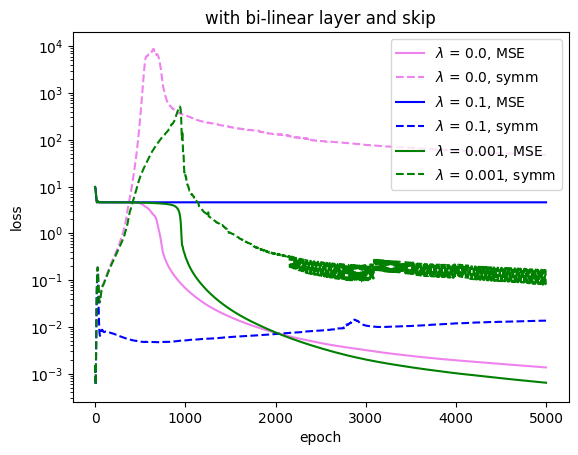

In [694]:
nepochs = 5000
color_vec = ["violet","blue","green","yellow","orange","red","pink"]
plt.figure()
for i,lam_val in enumerate(models_bi_SGD.keys()):
    plt.semilogy(range(len(train_loss_lam_bi_SGD[lam_val])),train_loss_lam_bi_SGD[lam_val],label = rf"$\lambda$ = {lam_val}, MSE", color = color_vec[i])
    plt.semilogy(range(len(symm_loss_lam_bi_SGD[lam_val])),symm_loss_lam_bi_SGD[lam_val],label = rf"$\lambda$ = {lam_val}, symm", color = color_vec[i],ls = "--")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("with bi-linear layer and skip")

Text(0.5, 1.0, 'with bi-linear layer')

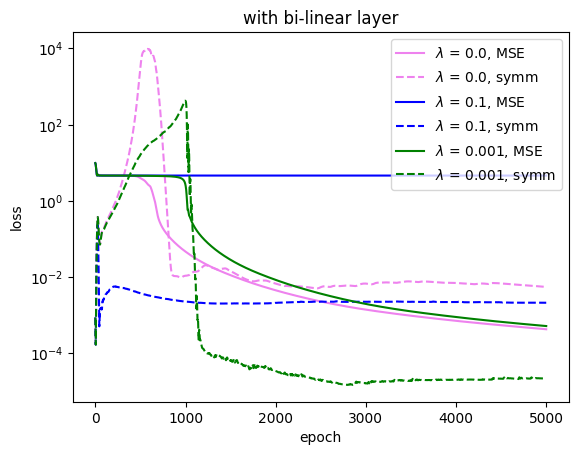

In [690]:
nepochs = 5000
color_vec = ["violet","blue","green","yellow","orange","red","pink"]
plt.figure()
for i,lam_val in enumerate(models_bi_SGD.keys()):
    plt.semilogy(range(len(train_loss_lam_bi_SGD[lam_val])),train_loss_lam_bi_SGD[lam_val],label = rf"$\lambda$ = {lam_val}, MSE", color = color_vec[i])
    plt.semilogy(range(len(symm_loss_lam_bi_SGD[lam_val])),symm_loss_lam_bi_SGD[lam_val],label = rf"$\lambda$ = {lam_val}, symm", color = color_vec[i],ls = "--")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("with bi-linear layer")

Text(0.5, 1.0, 'with bi-linear layer')

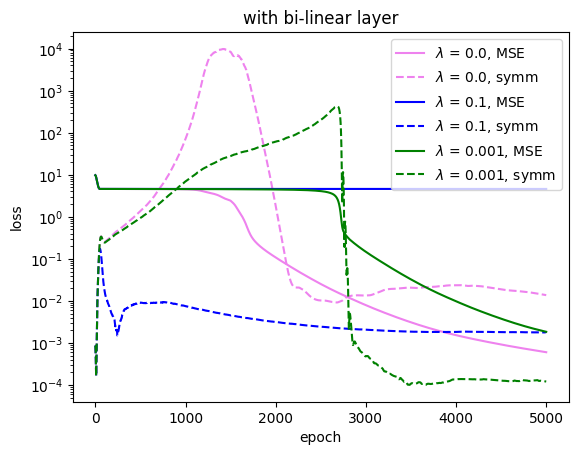

In [688]:
nepochs = 5000
color_vec = ["violet","blue","green","yellow","orange","red","pink"]
plt.figure()
for i,lam_val in enumerate(models_bi_SGD.keys()):
    plt.semilogy(range(len(train_loss_lam_bi_SGD[lam_val])),train_loss_lam_bi_SGD[lam_val],label = rf"$\lambda$ = {lam_val}, MSE", color = color_vec[i])
    plt.semilogy(range(len(symm_loss_lam_bi_SGD[lam_val])),symm_loss_lam_bi_SGD[lam_val],label = rf"$\lambda$ = {lam_val}, symm", color = color_vec[i],ls = "--")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("with bi-linear layer")

torch.Size([1000])
torch.Size([1000])


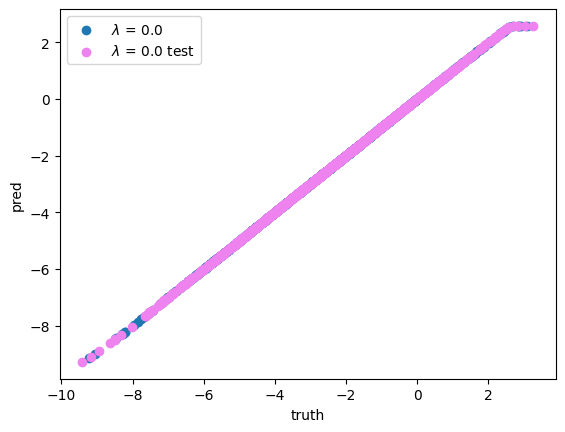

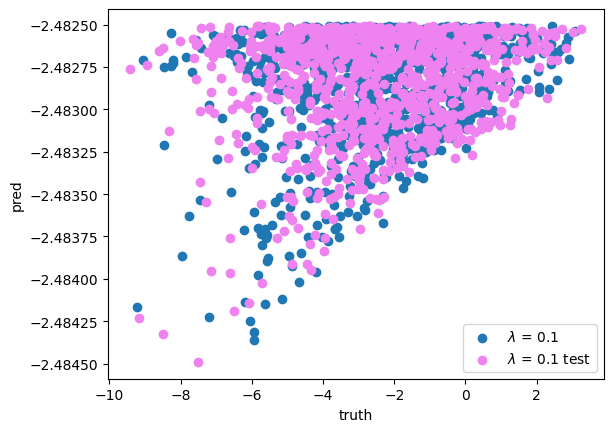

In [686]:

dinput = 4
N = 1000
norm = 1

more_inputs = ((torch.rand(N,dinput)-0.5)*norm).to(devicef)
for lam_val in models_bi_SGD.keys():
    plt.figure()
    plt.scatter(labels.cpu().squeeze(),models_bi_SGD[lam_val](inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val}")
    plt.scatter(true_fun(more_inputs).cpu().squeeze(),models_bi_SGD[lam_val](more_inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val} test",color = "violet")
    plt.legend()
    plt.xlabel("truth")
    plt.ylabel("pred")

No bi-linear layer

In [627]:

nepochs = 10000
# Define the loss function and optimizer

lam= [0.0, 0.000001,0.01,0.1, 1,10]
#optimizer_restricted = optim.SGD(model_restricted.parameters(), lr=1e-3, momentum=0.9)

# Train the model, store train and test loss, print the loss every epoch
train_loss = []
symm_loss_vec = []
tot_loss_vec = []
running_loss = 0.0
symm_loss = 0.0
# train_loss_lam_no_equiv = {}
# symm_loss_lam_no_equiv = {}
# tot_loss_lam_no_equiv = {}
# models_no_equiv = {}


for lam_val in lam[1:2]:

    np.random.seed(98235)
    torch.manual_seed(98235)
    modelLorentz_symm = genNet(input_size = 4, init = "rand",equiv="False",rand="False")
    #lossLorentz_symm = SymmLoss(gens_list=gens_Lorentz, model = modelLorentz_symm)
    #loss_res = lossLorentz_gen(input = train_data)

    model = modelLorentz_symm.to(devicef)
   
    # Define the loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    criterion_Lorentz = SymmLoss(gens_list=gens_Lorentz, model = model)

    train_loss = []
    symm_loss_vec = []
    tot_loss_vec = []
    running_loss = 0.0
    symm_loss = 0.0

    for epoch in range(nepochs):
        model.train()
        running_loss = 0.0
        symm_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            labels = torch.unsqueeze(labels.to(devicef),1)
            inputs = inputs.to(devicef)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_symm = criterion_Lorentz(input = inputs)
            loss_tot = loss+lam_val*loss_symm
            loss_tot.backward()
            optimizer.step()
            running_loss += loss.item()
            symm_loss += loss_symm.item()
        train_loss.append(running_loss / len(train_loader))
        symm_loss_vec.append(symm_loss / len(train_loader))
        tot_loss_vec.append((lam_val*symm_loss+running_loss) / len(train_loader))
        if epoch % 100 == 0:
            print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:}, Lorentz loss: {symm_loss_vec[-1]:}")
            #print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")

    
    train_loss_lam_no_equiv[lam_val] = train_loss
    symm_loss_lam_no_equiv[lam_val] = symm_loss_vec
    tot_loss_lam_no_equiv[lam_val] = tot_loss_vec
    #model.attribute = list(model.attribute)  # where attribute was dict_keys
    model_clone = copy.deepcopy(model)
    models_no_equiv[lam_val] = model_clone#model.load_state_dict(model.state_dict())
   
        

lambda = 1e-06 Epoch 1, MSE loss: 9.738852500915527, Lorentz loss: 0.00037687155418097973
lambda = 1e-06 Epoch 101, MSE loss: 7.556464672088623, Lorentz loss: 0.9864528775215149
lambda = 1e-06 Epoch 201, MSE loss: 4.42520809173584, Lorentz loss: 130.09634399414062
lambda = 1e-06 Epoch 301, MSE loss: 4.1890387535095215, Lorentz loss: 346.7809753417969
lambda = 1e-06 Epoch 401, MSE loss: 3.651007890701294, Lorentz loss: 1369.1419677734375
lambda = 1e-06 Epoch 501, MSE loss: 2.6054298877716064, Lorentz loss: 6573.076171875
lambda = 1e-06 Epoch 601, MSE loss: 1.7146724462509155, Lorentz loss: 14862.34375
lambda = 1e-06 Epoch 701, MSE loss: 0.8880729079246521, Lorentz loss: 16060.431640625
lambda = 1e-06 Epoch 801, MSE loss: 0.6031787395477295, Lorentz loss: 14392.525390625
lambda = 1e-06 Epoch 901, MSE loss: 0.5301730036735535, Lorentz loss: 14076.1728515625
lambda = 1e-06 Epoch 1001, MSE loss: 0.4680558145046234, Lorentz loss: 13744.2177734375
lambda = 1e-06 Epoch 1101, MSE loss: 0.401832

Text(0, 0.5, 'symm loss')

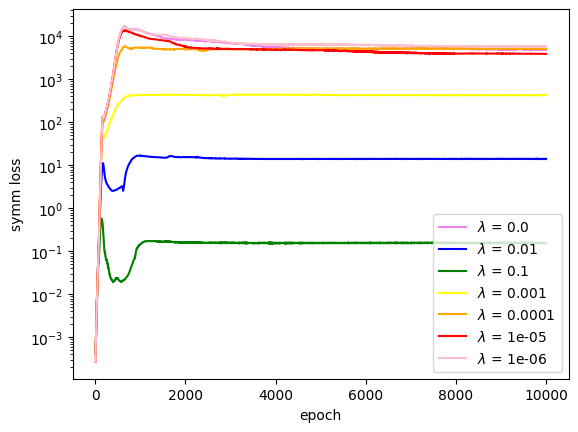

In [630]:
color_vec = ["violet","blue","green","yellow","orange","red","pink"]
plt.figure()
for i,lam_val in enumerate(models_no_equiv.keys()):
    plt.semilogy(range(nepochs),symm_loss_lam_no_equiv[lam_val],label = rf"$\lambda$ = {lam_val}", color = color_vec[i])
plt.legend()
plt.xlabel("epoch")
plt.ylabel("symm loss")


Text(0, 0.5, 'MSE loss')

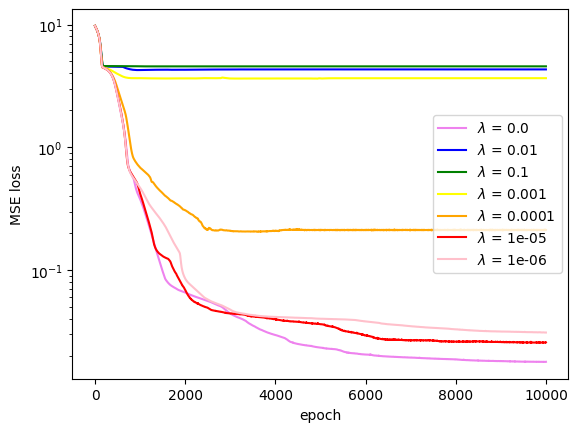

In [675]:
color_vec = ["violet","blue","green","yellow","orange","red","pink"]
plt.figure()
for i,lam_val in enumerate(models_no_equiv.keys()):
    plt.semilogy(range(len(train_loss_lam_no_equiv[lam_val])),train_loss_lam_no_equiv[lam_val],label = rf"$\lambda$ = {lam_val}", color = color_vec[i])
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE loss")

Text(0, 0.5, 'symm loss')

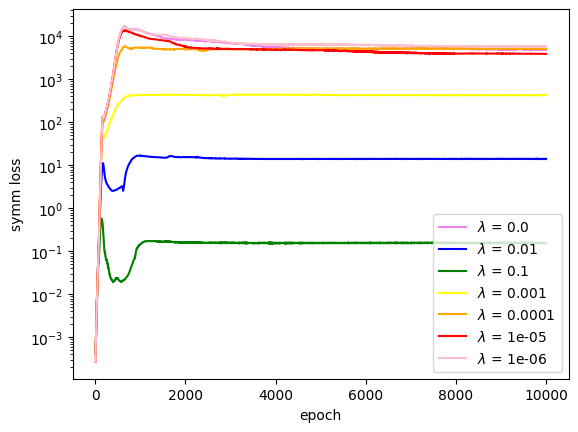

In [672]:

color_vec = ["violet","blue","green","yellow","orange","red","pink"]
plt.figure()
for i,lam_val in enumerate(models_no_equiv.keys()):
    plt.semilogy(range(len(symm_loss_lam_no_equiv[lam_val])),symm_loss_lam_no_equiv[lam_val],label = rf"$\lambda$ = {lam_val}", color = color_vec[i])
plt.legend()
plt.xlabel("epoch")
plt.ylabel("symm loss")

In [666]:
def true_fun(input):
    input =input.to(devicef)
    m2 = torch.einsum("... i, ij, ...j -> ...",input, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])).to(devicef), input)
    print(m2.shape)
    out = m2**2+15*m2
    return out.to(devicef).unsqueeze(1)

torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


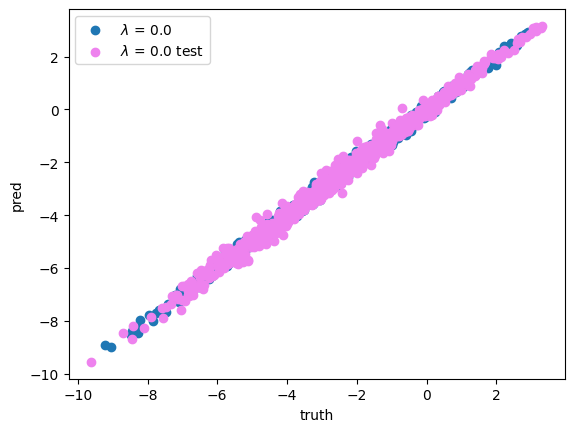

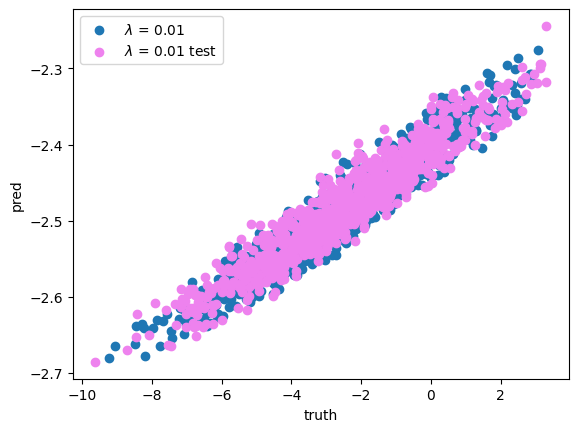

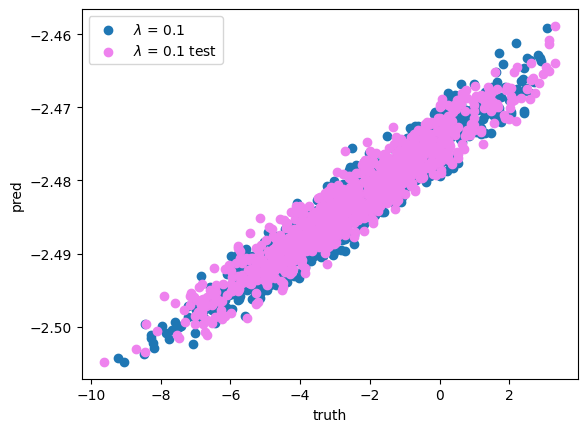

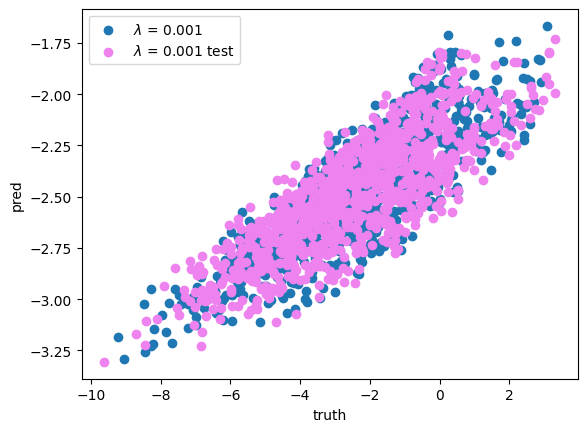

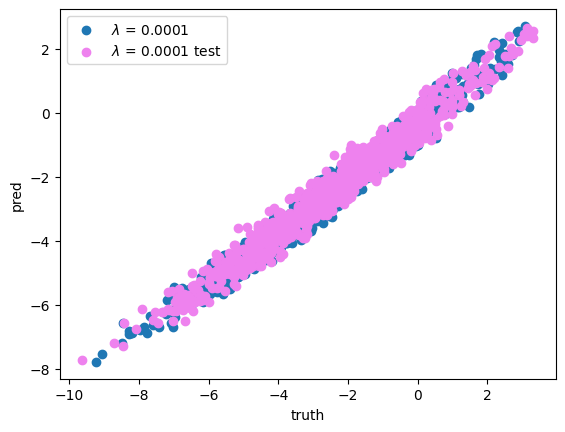

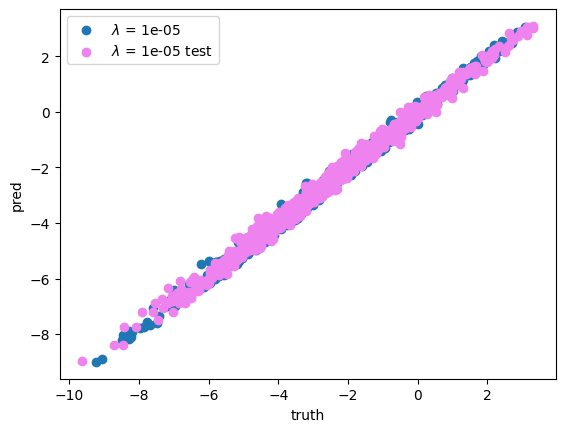

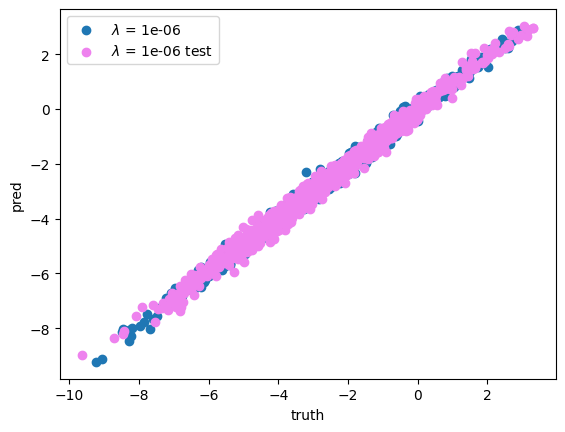

In [671]:

dinput = 4
N = 1000
norm = 1

more_inputs = ((torch.rand(N,dinput)-0.5)*norm).to(devicef)
for lam_val in models_no_equiv.keys():
    plt.figure()
    plt.scatter(labels.cpu().squeeze(),models_no_equiv[lam_val](inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val}")
    plt.scatter(true_fun(more_inputs).cpu().squeeze(),models_no_equiv[lam_val](more_inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val} test",color = "violet")
    plt.legend()
    plt.xlabel("truth")
    plt.ylabel("pred")


Sigmoid no bi-linear

In [678]:

nepochs = 10000
# Define the loss function and optimizer

lam= [0.0, 0.000001,0.01,0.1]
#optimizer_restricted = optim.SGD(model_restricted.parameters(), lr=1e-3, momentum=0.9)

# Train the model, store train and test loss, print the loss every epoch
train_loss = []
symm_loss_vec = []
tot_loss_vec = []
running_loss = 0.0
symm_loss = 0.0
train_loss_lam_no_equiv_sig = {}
symm_loss_lam_no_equiv_sig = {}
tot_loss_lam_no_equiv_sig = {}
models_no_equiv_sig = {}


for lam_val in lam:

    np.random.seed(98235)
    torch.manual_seed(98235)
    modelLorentz_symm = genNet(input_size = 4, init = "rand",equiv="False",rand="False",activation="sigmoid")
    #lossLorentz_symm = SymmLoss(gens_list=gens_Lorentz, model = modelLorentz_symm)
    #loss_res = lossLorentz_gen(input = train_data)

    model = modelLorentz_symm.to(devicef)
   
    # Define the loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    criterion_Lorentz = SymmLoss(gens_list=gens_Lorentz, model = model)

    train_loss = []
    symm_loss_vec = []
    tot_loss_vec = []
    running_loss = 0.0
    symm_loss = 0.0

    for epoch in range(nepochs):
        model.train()
        running_loss = 0.0
        symm_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            labels = torch.unsqueeze(labels.to(devicef),1)
            inputs = inputs.to(devicef)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_symm = criterion_Lorentz(input = inputs)
            loss_tot = loss+lam_val*loss_symm
            loss_tot.backward()
            optimizer.step()
            running_loss += loss.item()
            symm_loss += loss_symm.item()
        train_loss.append(running_loss / len(train_loader))
        symm_loss_vec.append(symm_loss / len(train_loader))
        tot_loss_vec.append((lam_val*symm_loss+running_loss) / len(train_loader))
        if epoch % 100 == 0:
            print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:}, Lorentz loss: {symm_loss_vec[-1]:}")
            #print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:.3f}, Lorentz loss: {symm_loss_vec[-1]:}")

    
    train_loss_lam_no_equiv_sig[lam_val] = train_loss
    symm_loss_lam_no_equiv_sig[lam_val] = symm_loss_vec
    tot_loss_lam_no_equiv_sig[lam_val] = tot_loss_vec
    #model.attribute = list(model.attribute)  # where attribute was dict_keys
    model_clone = copy.deepcopy(model)
    models_no_equiv_sig[lam_val] = model_clone#model.load_state_dict(model.state_dict())
   
        

lambda = 0.0 Epoch 1, MSE loss: 10.568805694580078, Lorentz loss: 4.889313458988909e-06
lambda = 0.0 Epoch 101, MSE loss: 7.350132942199707, Lorentz loss: 3.7271460314514115e-05
lambda = 0.0 Epoch 201, MSE loss: 5.368480682373047, Lorentz loss: 0.0010524820536375046
lambda = 0.0 Epoch 301, MSE loss: 4.714174747467041, Lorentz loss: 0.003763801883906126
lambda = 0.0 Epoch 401, MSE loss: 4.6076178550720215, Lorentz loss: 0.006757866591215134
lambda = 0.0 Epoch 501, MSE loss: 4.596188545227051, Lorentz loss: 0.01050497218966484
lambda = 0.0 Epoch 601, MSE loss: 4.595244884490967, Lorentz loss: 0.01523306593298912
lambda = 0.0 Epoch 701, MSE loss: 4.595038414001465, Lorentz loss: 0.020984556525945663
lambda = 0.0 Epoch 801, MSE loss: 4.594846725463867, Lorentz loss: 0.027920950204133987
lambda = 0.0 Epoch 901, MSE loss: 4.594633102416992, Lorentz loss: 0.03631787374615669
lambda = 0.0 Epoch 1001, MSE loss: 4.594390869140625, Lorentz loss: 0.04653933644294739
lambda = 0.0 Epoch 1101, MSE lo

Text(0, 0.5, 'MSE loss')

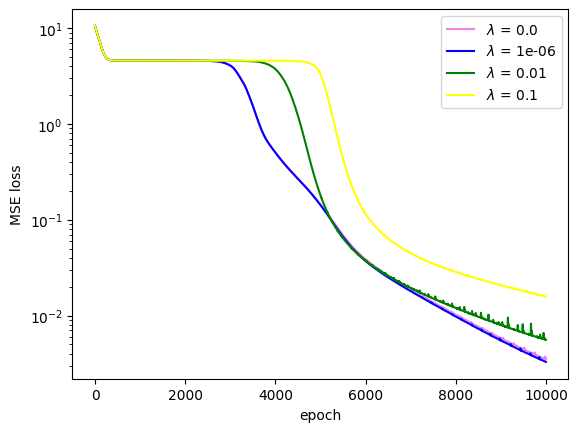

In [679]:
color_vec = ["violet","blue","green","yellow","orange","red","pink"]
plt.figure()
for i,lam_val in enumerate(models_no_equiv_sig.keys()):
    plt.semilogy(range(len(train_loss_lam_no_equiv_sig[lam_val])),train_loss_lam_no_equiv_sig[lam_val],label = rf"$\lambda$ = {lam_val}", color = color_vec[i])
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE loss")

In [ ]:
def LorentzLoss(nn.Module):

#We work with p^\mu
    def __init__(self, device, model):
        super(LorentzLoss, self).__init__()

        self.model = model
        self.device = device

        #Generators 





        #gradients


    

In [ ]:
def LorentzSymmNet(nn.Module):

    def __init__(self):
        

Reproduce Nadav's results

In [ ]:
## Generate the dataset
np.random.seed(98235)
torch.manual_seed(98235)

N = 2000  # number of data points

# Training data
train_data_2D = np.random.rand(N, 2) * 2 - 1  # Generate random points in [-1, 1] x [-1, 1]
train_labels_2D = np.sqrt(train_data_2D[:, 0]**2 + train_data_2D[:, 1]**2) > 1/2  # Calculate r and assign labels
train_labels_2D = train_labels_2D.astype(np.float32)

# Plot the data
plt.figure()
plt.scatter(train_data_2D[train_labels_2D == 0, 0], train_data_2D[train_labels_2D == 0, 1], s=1)
plt.scatter(train_data_2D[train_labels_2D == 1, 0], train_data_2D[train_labels_2D == 1, 1], s=1)
plt.axis('equal')
plt.show()

# Test data
test_data = np.random.rand(N//5, 2) * 2 - 1
test_labels = np.sqrt(test_data[:, 0]**2 + test_data[:, 1]**2) > 1/2
test_labels = test_labels.astype(np.float32)

# partial data, keep only data with x > 0
train_data_restriced = train_data[train_data[:, 0] > 0]
train_labels_restriced = train_labels[train_data[:, 0] > 0]



# Convert to PyTorch tensors and create loaders
train_data = torch.tensor(train_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

test_data = torch.tensor(test_data, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

train_data_restriced = torch.tensor(train_data_restriced, dtype=torch.float32)
train_labels_restriced = torch.tensor(train_labels_restriced, dtype=torch.float32)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
train_dataset_restricted = TensorDataset(train_data_restriced, train_labels_restriced)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_loader_restricted = DataLoader(train_dataset_restricted, batch_size=32, shuffle=True)